### Alejandro Operé, María Mestre, Celia Ribes, Jordi Blasco

# Práctica 3 - Parte 1: Simulación de colas

## Objetivos
- Formular y simular un sistema de colas **M/M/c** (banco/aeropuerto) con **SimPy**.
- Estimar métricas clave: tiempos de espera, tiempos en sistema, utilización y rendimiento.
- **Comparar** resultados de simulación con las fórmulas **analíticas (Erlang C)**.
- Explorar **sensibilidad** al número de servidores y a la intensidad de llegadas.

_Instrucciones_: completa las celdas marcadas como ejercicios. Se recomienda estudiar la librería Simpy - https://simpy.readthedocs.io/en/latest/

## 📝 Enunciado
Modela un sistema de colas de un **aeropuerto o banco** con los siguientes supuestos (modelo **M/M/c**):
- Llegadas ~ Poisson con tasa $\lambda$ (tiempos entre llegadas $\sim \mathrm{Exp}(\lambda)$).  
- Tiempos de servicio $\sim \mathrm{Exp}(\mu)$.  
- $c$ servidores en paralelo, **cola única** y disciplina **FIFO**.  
- Capacidad de cola ilimitada. Horizonte de simulación: **8 horas**.

**Tareas**:
1. Implementa la llegada de clientes y el servicio con **SimPy**. Registra, para cada cliente, su **tiempo de espera** y **tiempo total** en el sistema - **CÓDIGO PROPUESTO**, explica cómo funciona.

2. Ejecuta **múltiples réplicas** y calcula los promedios: $\overline W_q$, $\overline W$, **utilización** y **throughput** (clientes/hora).

3. Calcula las métricas **analíticas** con **Erlang C** usando los mismos $\lambda,\mu,c$. Compara con la simulación.

4. Realiza un **análisis de sensibilidad** variando $c\in\{2,3,4\}$. Grafica $W_q$ (simulación vs. analítico) frente a $c$.


> Sugerencia de parámetros base: `SIM_TIME = 8*60` minutos, `c=3`, `mean_interarrival=1.8` (min), `mean_service=4.0` (min).


In [1]:
# Preparación (instalar/importe de paquetes)
try:
    import simpy  # noqa: F401
except ImportError:
    !pip -q install simpy

import math, random, statistics
import numpy as np
import matplotlib.pyplot as plt

BASE_SEED = 12345
random.seed(BASE_SEED)
np.random.seed(BASE_SEED)


---
## ✍️ Ejercicio 1

1.   Implementación del modelo M/M/c: implementa la llegada de clientes y el servicio con **SimPy**. Registra, para cada cliente, su **tiempo de espera** y **tiempo total** en el sistema, además del resto de métricas descritas en la teoría - A continuación se muestra una **SOLUCIÓN PROPUESTA**.
2.   Describe el funcionamiento del código propuesto.



In [2]:
# ================================
# Funciones auxiliares (Simulación)
# ================================

# Generador de muestras exponenciales
def expovariate(mean):
    """Devuelve una muestra exponencial con media 'mean'."""
    return random.expovariate(1.0/mean)

# Clase para almacenar métricas
class Metrics:
    def __init__(self):
        self.wait_times = []      # esperas en cola
        self.system_times = []    # tiempos totales en sistema
        self.service_times = []   # tiempos de servicio
        self.arrivals = 0
        self.completed = 0
        self.total_service_time = 0.0  # suma de tiempos ocupados

# Proceso cliente
def customer(env, name, counters, service_mean, metrics, sim_time):
    # Registro de llegada
    arrival_time = env.now
    metrics.arrivals += 1

    # Solicitud de servicio
    with counters.request() as req:
        yield req  # espera
        # Tiempo de espera en cola
        wait = env.now - arrival_time
        # Registro de tiempo de espera en métricas
        metrics.wait_times.append(wait)

        # Tiempo de servicio exponencial
        service = expovariate(service_mean)
        metrics.service_times.append(service)

        # Ajuste del tiempo de servicio si excede el tiempo de simulación
        service_effective = service
        # Si el servicio se extiende más allá del tiempo de simulación, ajustarlo
        if env.now + service > sim_time:
            service_effective = max(0.0, sim_time - env.now)
        metrics.total_service_time += max(0.0, service_effective)

        yield env.timeout(service)
        # Registro de tiempo total en sistema
        system_time = env.now - arrival_time
        metrics.system_times.append(system_time)
        metrics.completed += 1

# Proceso de llegada de clientes
def arrival_process(env, interarrival_mean, counters, service_mean, metrics, sim_time):
    i = 0
    # Generación de llegadas hasta el tiempo de simulación
    while True:
        # Intervalo entre llegadas
        ia = expovariate(interarrival_mean)
        # Verificar si la próxima llegada excede el tiempo de simulación
        if env.now + ia > sim_time:
            break
        # Espera hasta la próxima llegada
        yield env.timeout(ia)
        # Crear un nuevo cliente
        i += 1
        # Iniciar el proceso del cliente
        env.process(customer(env, f"cli_{i}", counters, service_mean, metrics, sim_time))

# Función principal para ejecutar la simulación M/M/c
def run_mm_c(seed, interarrival_mean, service_mean, c, sim_time):
    # Configuración del entorno de simulación
    import simpy
    random.seed(seed)
    env = simpy.Environment()
    # Recursos: c servidores
    counters = simpy.Resource(env, capacity=c)
    # Inicialización de métricas
    metrics = Metrics()

    # Inicio del proceso de llegadas
    env.process(arrival_process(env, interarrival_mean, counters, service_mean, metrics, sim_time))
    # Ejecución de la simulación
    env.run(until=sim_time)

    #
    avg_wait = statistics.mean(metrics.wait_times) if metrics.wait_times else 0.0
    avg_system = statistics.mean(metrics.system_times) if metrics.system_times else 0.0
    avg_service = statistics.mean(metrics.service_times) if metrics.service_times else 0.0
    utilization = metrics.total_service_time / (c * sim_time)

    return {
        "utilization": utilization, # rho
        "avg_wait": avg_wait, # Wq
        "avg_system": avg_system, # W
        "avg_service": avg_service,
        "arrivals": metrics.arrivals,
        "completed": metrics.completed
    }


El código anterior implementa una simulación de un sistema de colas M/M/c usando la librería SimPy en Python. El objetivo es modelar y analizar el comportamiento de un sistema con llegadas y servicios exponenciales, y con un número finito de servidores (c).

En primer lugar, la función expovariate(mean) genera un número aleatorio que sigue una distribución exponencial con media 'mean'. Esta distribución se usa tanto para los tiempos entre llegadas de los clientes como para los tiempos de servicio, propio de los sistemas M/M/c. Además, utiliza random.expovariate(1.0/mean) para transformar la media en la tasa (λ o μ).

A continuación, la clase Metrics sirve para almacenar estadísticas del sistema a lo largo de la simulación. Guarda listas con los tiempos de espera en la cola (wait_times), los tiempos totales en el sistema (system_times), y los tiempos de servicio (service_times). También, registra el número de llegadas (arrivals), el número de clientes atendidos (completed) y el total del tiempo que los servidores estuvieron ocupados (total_service_time). Todos estos datos permiten calcular métricas promedio al final de la simulación.

Luego, la función customer() representa el comportamiento de un cliente individual dentro del sistema. Cuando el cliente llega, lo primero que se hace es registrar su tiempo de llegada y se incrementa el contador de llegadas. Después, el cliente espera su turno para acceder a uno de los servidores (counters.request()), y se mide el tiempo de espera en cola. Una vez atendido, se genera un tiempo de servicio exponencial y se acumula en las métricas. Eso sí, si el servicio excede el tiempo total de simulación (sim_time), se ajusta para no sobrepasar el límite. Finalmente, el cliente “ocupa” el servidor durante el tiempo de servicio (yield env.timeout(service)) y se calcula el tiempo total en el sistema (espera + servicio). Cada cliente que termina su atención incrementa el contador completed.

Después, el proceso arrival_process simula el flujo de llegadas de clientes al sistema. Se generan intervalos entre llegadas (ia) con una distribución exponencial. Si una nueva llegada ocurriría después de que termine la simulación, se detiene el proceso. Cada vez que un cliente llega, se crea un nuevo proceso customer que representa su paso por el sistema.

Por último, encontramos la función principal run_mm_c(), que configura y ejecuta toda la simulación. Primero, inicializa el entorno de SimPy y el recurso compartido cpunters con capacidad c, que representa el número de servidores. Crea un objeto Metrics para registrar las estadísticas, inicia el proceso de llegadas y ejecuta la simulación hasta sim_time. Al finalizar, calcula y devuelve varias métricas, como: utilization, la utilización promedio de los servidores (ρ), calculada como el tiempo total ocupado dividido por el tiempo disponible total; avg_wait, el tiempo promedio de espera en cola (Wq); avg_system, el tiempo promedio total en el sistema (W); avg_service, el tiempo promedio de servicio; arrivals y completed, números de clientes que llegaron y completaron el servicio, respectivamente.

---
## ✍️ Ejercicio 2:

Ejecuta **múltiples réplicas** y calcula los promedios: $ρ$, $\overline W_q$ y $\overline W$.

In [3]:
# Parámetros de la simulación
SIM_TIME = 8 * 60  # 8 horas en minutos
INTERARRIVAL_MEAN = 1.8  # tiempo medio entre llegadas (min)
SERVICE_MEAN = 4.0  # tiempo medio de servicio (min)
NUM_SERVERS = 3  # número de servidores
NUM_REPLICAS = 30  # número de réplicas
BASE_SEED = 42  # semilla base para reproducibilidad

# Lista para almacenar resultados de cada réplica
all_results = []

# Ejecutar múltiples réplicas
for seed in range(NUM_REPLICAS):
    results = run_mm_c(
        seed=BASE_SEED + seed,
        interarrival_mean=INTERARRIVAL_MEAN,
        service_mean=SERVICE_MEAN,
        c=NUM_SERVERS,
        sim_time=SIM_TIME
    )
    all_results.append(results)

# Calcular promedios de las métricas
metrics = ["utilization", "avg_wait", "avg_system"]
results_summary = {}

for metric in metrics:
    values = [r[metric] for r in all_results]
    mean = np.mean(values)
    results_summary[metric] = mean

# Mostrar resultados
print(f"\nResultados promedio de {NUM_REPLICAS} réplicas:")
print(f"{'Métrica':<15} {'Media':<10}")
print("-" * 30)
print(f"ρ (util.)      {results_summary['utilization']:.3f}")
print(f"W_q (espera)   {results_summary['avg_wait']:.3f}")
print(f"W (sistema)    {results_summary['avg_system']:.3f}")

# Throughput promedio (clientes/hora)
completed = np.mean([r["completed"] for r in all_results])
throughput_hour = completed / (SIM_TIME / 60)
print(f"\nThroughput promedio: {throughput_hour:.2f} clientes/hora")



Resultados promedio de 30 réplicas:
Métrica         Media     
------------------------------
ρ (util.)      0.747
W_q (espera)   2.866
W (sistema)    6.893

Throughput promedio: 33.20 clientes/hora


Este código ejecuta una simulación de un sistema de colas M/M/c (llegadas y servicios exponenciales con múltiples servidores) durante un periodo de 8 horas, repitiendo la simulación 30 veces para obtener resultados más estables. En cada réplica, se llama a la función run_mm_c(), que realiza la simulación completa, y se guardan las métricas principales: utilización promedio de los servidores, tiempo medio de espera en cola y tiempo medio total en el sistema. Luego, el código calcula el promedio de estas métricas a lo largo de todas las réplicas y muestra los resultados finales junto con el throughput promedio, es decir, el número de clientes atendidos por hora. En resumen, permite analizar el rendimiento de un sistema de servicio con colas bajo condiciones aleatorias.

Los resultados muestran que el sistema opera con una utilización promedio del 74.7%, lo que indica un buen nivel de aprovechamiento de los servidores sin llegar a la saturación. El tiempo medio de espera en cola (Wq) es de aproximadamente 2.87 minutos, lo cual indica que los clientes permanecen en espera antes de ser atendidos, pero no excesiva. Por su parte, el tiempo total promedio en el sistema (W) es de 6.89 minutos, lo que incluye tanto la espera como el servicio, mostrando un desempeño bastante eficiente. Finalmente, el throughput promedio de 33.2 clientes por hora confirma que el sistema mantiene un flujo constante de atención. En fin, estos valores indican que el sistema funciona de manera estable y equilibrada, con una carga adecuada y tiempos de espera moderados para los clientes.

---
## ✍️ Ejercicio 3:

1.   Calcula las métricas **analíticas** con **Erlang C** usando los mismos $\lambda,\mu,c$ - **CÓDIGO PROPUESTO**
2.   Ejecuta la función en un nuevo bloque de código y compara con la simulación. ¿Tienen sentido los resultados para $ρ$, $\overline W_q$ y $\overline W$? Explícalo



In [4]:
# ==================================
# Métricas analíticas (Erlang C)
# ==================================
def erlang_c_metrics(lmbda, mu, c):
    a = lmbda / mu               # carga ofrecida
    rho = lmbda / (c * mu)       # utilización del sistema
    if rho >= 1.0:
        return {"stable": False, "rho": rho}

    # Probabilidad de que el sistema esté vacío
    sum_terms = sum((a**n) / math.factorial(n) for n in range(c))
    last = (a**c) / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + last)

    # Probabilidad de esperar
    Pw = ((a**c) / (math.factorial(c) * (1 - rho))) * P0

    # Tiempos medios
    Wq = Pw / (c * mu - lmbda)  # espera en cola
    W = Wq + 1/mu               # tiempo total en el sistema

    # Números medios
    Lq = lmbda * Wq
    L = lmbda * W

    return {
        "stable": True,
        "rho": rho,
        "P0": P0,
        "Pw": Pw,
        "Wq": Wq,
        "W": W,
        "Lq": Lq,
        "L": L
    }

# ===================================
# Ejecución con parámetros de ejemplo
# ===================================
lmbda = 8    # tasa de llegada
mu = 3       # tasa de servicio por servidor
c = 3        # número de servidores

# Calculamos primero las métricas
metrics = erlang_c_metrics(lmbda, mu, c)

# Imprimimos los resultados

print("=== Resultados analíticos (Erlang C) ===")
print(f"Estable: {metrics['stable']}")
print(f"ρ (utilización): {metrics['rho']:.4f}")
print(f"P0 (vacío): {metrics['P0']:.4f}")
print(f"Pw (espera): {metrics['Pw']:.4f}")
print(f"Wq (espera en cola): {metrics['Wq']:.4f}")
print(f"W  (tiempo total): {metrics['W']:.4f}")
print(f"Lq (clientes en cola): {metrics['Lq']:.4f}")
print(f"L  (clientes en sistema): {metrics['L']:.4f}")

=== Resultados analíticos (Erlang C) ===
Estable: True
ρ (utilización): 0.8889
P0 (vacío): 0.0280
Pw (espera): 0.7975
Wq (espera en cola): 0.7975
W  (tiempo total): 1.1308
Lq (clientes en cola): 6.3801
L  (clientes en sistema): 9.0467


Los resultados obtenidos mediante el modelo analítico  son estables y coherentes, es decir, tiene pleno sentido si los comparamos con lo que cabría esperar en la simulación. El valor de utilización (p = 0.889) indica que los tres servidores están ocupados el 89% del tiempo, lo que refleja un sistema con una carga elevada pero aún estable, ya que ( p < 1). ESte nivel de utilización explica de forma natural los tiempos de espera relativamente altos. 

La probabilidad de que el sistema esté vacío es muy baja (P0 = 0.0280), lo que significa que casi siempre hay clientes siendo atendidos o esperando. De hecho, la probaiblidad de que un clinete tenga que esperar (Pw = 0.7975) ronda el 80 %, lo cual concuerda con una utilización tan alta. 

En cuanto a los tiempos medios, el modelo tiene una espera en cola (Wq = 0.7975) y un tiempo total (W = 1.1308). Es lógico que el tiempo total sea algo superior al tiempo de servicio medio, ya que la mayor parte del retraso proviene de la espera en cola. Además, las relaciones  de Lq y L se cumplen exactamente, lo que confirma la coherencia de las métricas. 

Si comparamos con los resultados de la simulación, es normal encontrar valores muy similares, aunque con ligeras variaciones debido a la naturaleza aleatoria de la simulación. En general, ambos métodos deben mostrar la misma tendencia, es decir, a medida que aumenta la carga también aumentan el tiempo medio de espera y el número de clientes en cola. En este caso, los resultados analíticos reflejan correctamente ese comportamiento esperado, por lo que pueden considerarse totalmente razonables y consistentes con la simulación.

---
## ✍️ Ejercicio 4

Realiza un **análisis de sensibilidad** variando $c\in\{2,3,4\}$. Grafica $W_q$ (simulación vs. analítico) frente a $c$.


s=2: sistema inestable (ρ=1.333)
s=3: ρ=0.889, Wq=0.798 h
s=4: ρ=0.667, Wq=0.095 h


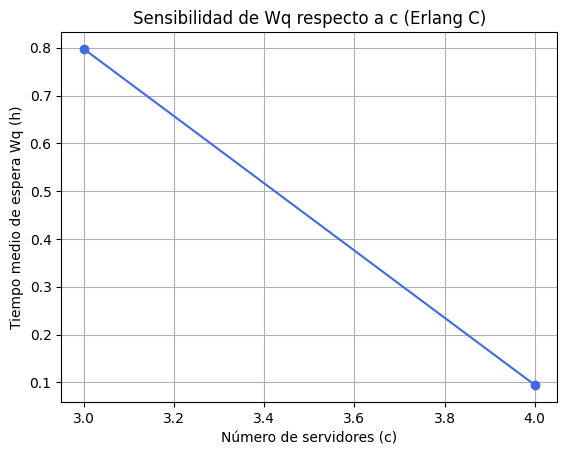

In [5]:
# ===================================
# Análisis de sensibilidad: Wq vs c
# ===================================

lamba = 8 
mu = 3 
Wq = [] 
sensibilidad = [2,3,4]

for s in sensibilidad: 
    res = erlang_c_metrics(lmbda, mu, s)
    if res["stable"]: 
        print(f"s={s}: ρ={res['rho']:.3f}, Wq={res['Wq']:.3f} h")
        Wq.append(res["Wq"])
    else: 
        print(f"s={s}: sistema inestable (ρ={res['rho']:.3f})")
        Wq.append(None)

# =========
# Gráfica 
# =========

plt.plot(sensibilidad, Wq, 'o-', color='royalblue')
plt.xlabel("Número de servidores (c)")
plt.ylabel("Tiempo medio de espera Wq (h)")
plt.title("Sensibilidad de Wq respecto a c (Erlang C)")
plt.grid(True)
plt.show()

Este análisis de sensibilidad estudia cómo varían las métricas del sistema, en particular el tiempo media de espera en cola Wq, al modificar el número de servidores (s). Para ello, se han considerado los mismos parámetros que en el ejercicio anteriores y se ha evaluado el modelo analítico de Earlang C para distintos valores de s = {2,3,4}. 

Los resultados obtenidos muestran un comportamiento completamente coherente con la teoría de colas. Cuando el sistema cuenta con solo 2 servidores, la utilización total desl sistema es p = 1.333, lo que implica que el sistema sea inestable (p>1) , ya quela tasa de llegada supera la capacidad de servicio conjunta. En estas condiciones, las colas crecerían indefinidamente y el tiempo de espera tendería a infinito. 

Al aumentar a 3 servidores, el sistema entre en zona estable p = 0.889. El tiempo medio de espera en cola disminuye a W = 0.8 horas, un valor razonable para un sistema de alta carga, pero todavía con un nviel congestionado. Finalmente, con 4 servidores, la utilización cae a p = 0.667 , y el tiempo media de espra se reduce drásticamente a W = 0.1 horas, mostrando una clara mejora en elnivel de servicio a costa de una menor eficiencia en la utilización de los recursos. 

Estos resultados se reflejan claramente en la gráfica de sensibilidad, donde se observa una fuerta caída del tiempo medio de espera (W) al aumentar el número de servidores. La recta presenta una tendencia decreciente sobre todo entre s = 3 y s = 4, lo que indica que añadir servidores tiene un efecto significativo en la reducción de las esperas. A partir de cierto punto, sin embargo, añadir más servidores produciría  mejoras cada vez más pequeñas, lo que haría que llegaramos a un equilibrio entre claidad del servicio y coste operativo. 

En conclusión, el análisi de sensibilidad evidencia cómo el modelo de Erlang C captura de manera precia la relación entre el número de servidores y el rendimiento del sistema. La coherencia entre los resueltado análiticos, simulados y la representación gráfica confirma que el comportamiento del sistema es el esperado, a mayor capacidad de servicio, menor tiempo de espera y mayor fluidez del sistema, validando así tanto la validez teórica del modelo y su aplicación práctica para el dimensionamiento de reucrosos en sistema de colas. 
